In [23]:
# 1) Imports & data load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path = "cps_combined_2018_2024_long.csv"  # update if your path differs
raw = pd.read_csv(path)

raw.shape, raw.dtypes

((68362, 6),
 SourceTable     object
 Year             int64
 RowLabel        object
 Metric          object
 Value          float64
 SourceFile      object
 dtype: object)

In [24]:
raw.head(10)

,SourceTable,Year,RowLabel,Metric,Value,SourceFile
0,cps_table1,1948,All,Civilian labor force Employed Agriculture,7629.0,cps_table1_2018_2024_long.csv
1,cps_table1,1949,All,Civilian labor force Employed Agriculture,7658.0,cps_table1_2018_2024_long.csv
2,cps_table1,1949,All,Civilian labor force Employed Agriculture,7658.0,cps_table1_2018_2024_long.csv
3,cps_table1,1950,All,Civilian labor force Employed Agriculture,7160.0,cps_table1_2018_2024_long.csv
4,cps_table1,1950,All,Civilian labor force Employed Agriculture,7160.0,cps_table1_2018_2024_long.csv
5,cps_table1,1950,All,Civilian labor force Employed Agriculture,7160.0,cps_table1_2018_2024_long.csv
6,cps_table1,1951,All,Civilian labor force Employed Agriculture,6726.0,cps_table1_2018_2024_long.csv
7,cps_table1,1951,All,Civilian labor force Employed Agriculture,6726.0,cps_table1_2018_2024_long.csv
8,cps_table1,1951,All,Civilian labor force Employed Agriculture,6726.0,cps_table1_2018_2024_long.csv
9,cps_table1,1951,All,Civilian labor force Employed Agriculture,6726.0,cps_table1_2018_2024_long.csv


In [25]:
# 3) Filter to years 2018–2024 and normalize the 'Metric' text
df = raw[raw["Year"].between(2018, 2024)].copy()
df["Metric_clean"] = df["Metric"].str.replace(r"^\s*(19|20)\d{2}\s+", "", regex=True).str.strip()
mask_notes = df["Metric_clean"].str.startswith(("NOTE", "Footnotes"), na=False)
df = df[~mask_notes].copy()

sector_keywords = [
    'Agriculture', 'Mining', 'Utilities', 'Construction', 'Manufacturing',
    'Wholesale', 'Retail', 'Transportation', 'Warehousing',
    'Information', 'Financial', 'Professional', 'Business',
    'Education', 'Health', 'Leisure', 'Hospitality', 'Government',
    'Public administration', 'Other services'
]
mask_sector = df["RowLabel"].str.contains("|".join(sector_keywords), case=False, na=False)

# Focus on Total employed by industry
df_emp = df[mask_sector & (df["Metric_clean"].str.fullmatch("Total employed", na=False))].copy()
df_emp = df_emp.dropna(subset=["Value"])

df_emp["Industry"] = df_emp["RowLabel"].str.replace(r"\s{2,}", " ", regex=True).str.strip()
bad_industry_tokens = ("Total,", "Total ", "TOTAL", "Men,", "Women,", "years", "Hispanic", "White", "Black", "Asian")
df_emp = df_emp[~df_emp["Industry"].str.startswith(bad_industry_tokens, na=False)].copy()

emp_agg = (
    df_emp.groupby(["Year", "Industry"], as_index=False)["Value"]
    .mean()
    .rename(columns={"Value": "Employed_thousands"})
)

emp_agg.head(10)

,Year,Industry,Employed_thousands
0,2018,Aerospace product and parts manufacturing,51.000000
1,2018,Agricultural chemical manufacturing,37.000000
2,2018,Agricultural implement manufacturing,114.000000
3,2018,Agriculture and related,1200.333333
4,2018,"Agriculture, forestry, fishing, and hunting",2425.000000
5,2018,Air transportation,635.000000
6,2018,Aircraft and parts manufacturing,805.000000
7,2018,Alcoholic beverages merchant wholesalers,115.000000
8,2018,Apparel accessories and other apparel manufact...,11.000000
9,2018,"Apparel, piece goods, and notions merchant who...",95.000000


In [26]:
# 4) Sanity checks
by_year = emp_agg.groupby("Year")["Employed_thousands"].sum().reset_index(name="Total_employed_all_industries")
top2024 = (
    emp_agg[emp_agg["Year"] == 2024]
    .sort_values("Employed_thousands", ascending=False)
    .head(15)
)
by_year, top2024

(   Year  Total_employed_all_industries
 0  2018                  225659.216667
 1  2019                  228146.116667
 2  2020                  217216.583333
 3  2021                  223966.600000
 4  2022                  230963.600000
 5  2023                  235132.550000
 6  2024                  235118.650000,
       Year                             Industry  Employed_thousands
 897   2024        Education and health services            22140.60
 915   2024    Health care and social assistance            17123.75
 977   2024   Professional and business services            12718.30
 1007  2024           Wholesale and retail trade            11628.10
 898   2024                 Educational services            10724.00
 979   2024  Professional and technical services            10396.50
 986   2024                         Retail trade             9727.30
 896   2024          Durable goods manufacturing             9691.00
 929   2024                        Manufacturing          

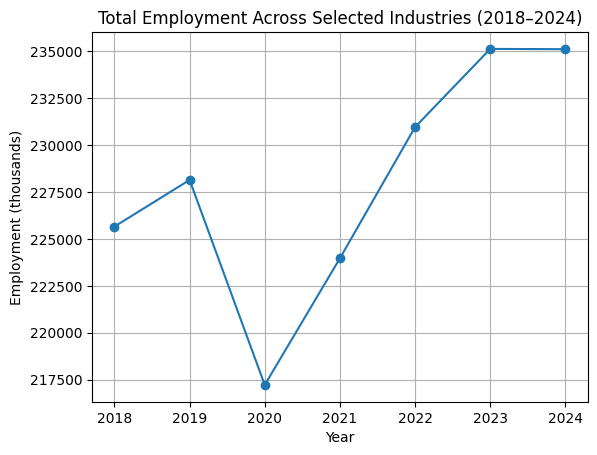

In [27]:
# 5) VIS 1: Total employment across industries (2018–2024)
plt.figure()
by_year_plot = emp_agg.groupby("Year")["Employed_thousands"].sum()
by_year_plot.plot(marker="o")
plt.title("Total Employment Across Selected Industries (2018–2024)")
plt.xlabel("Year")
plt.ylabel("Employment (thousands)")
plt.grid(True)
plt.show()


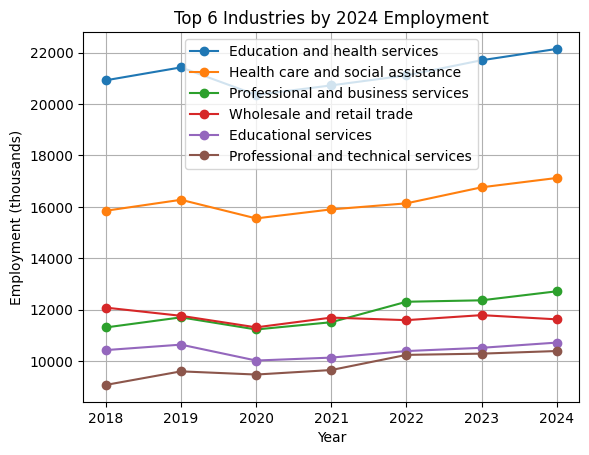

In [28]:
# 6) VIS 2: Top 6 industries by 2024 employment (multi-line)
topN = (
    emp_agg[emp_agg["Year"] == 2024]
    .nlargest(6, "Employed_thousands")["Industry"]
    .tolist()
)

plt.figure()
for ind in topN:
    xs = emp_agg.loc[emp_agg["Industry"] == ind, "Year"]
    ys = emp_agg.loc[emp_agg["Industry"] == ind, "Employed_thousands"]
    plt.plot(xs, ys, marker="o", label=ind)

plt.title("Top 6 Industries by 2024 Employment")
plt.xlabel("Year")
plt.ylabel("Employment (thousands)")
plt.grid(True)
plt.legend()
plt.show()

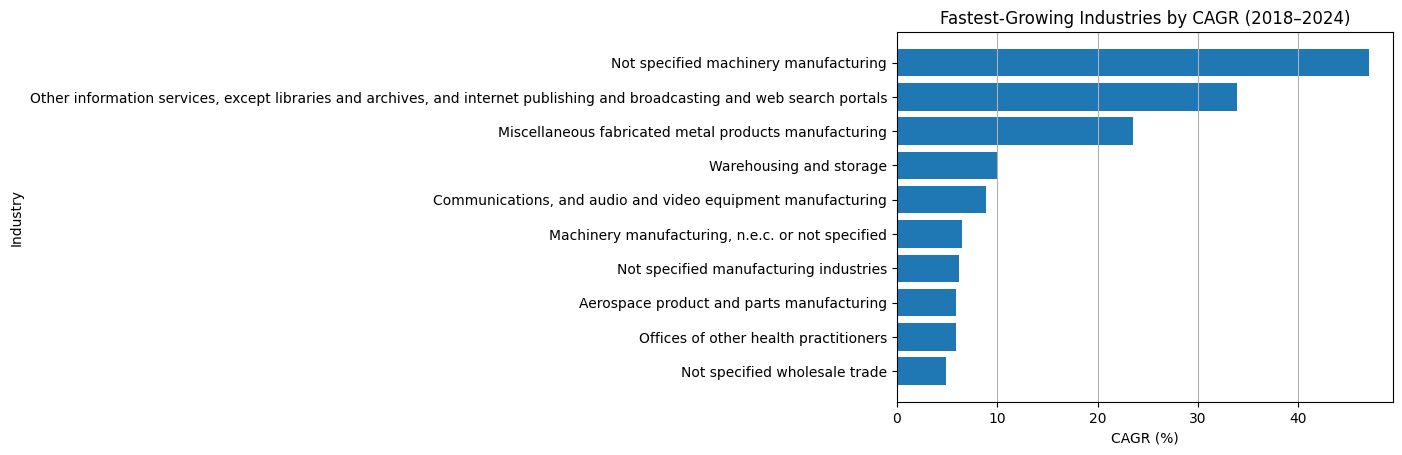

In [29]:
# 7) VIS 3: Fastest-growing industries by CAGR
pivot_emp = emp_agg.pivot(index="Year", columns="Industry", values="Employed_thousands").sort_index()

def cagr(series: pd.Series):
    s = series.dropna()
    if len(s) < 2:
        return np.nan
    n_years = s.index.max() - s.index.min()
    if n_years <= 0:
        return np.nan
    return (s.iloc[-1] / s.iloc[0]) ** (1 / n_years) - 1

cagr_vals = pivot_emp.apply(cagr, axis=0).mul(100).sort_values(ascending=False).dropna().head(10)

plt.figure()
plt.barh(cagr_vals.index, cagr_vals.values)
plt.title("Fastest-Growing Industries by CAGR (2018–2024)")
plt.xlabel("CAGR (%)")
plt.ylabel("Industry")
plt.gca().invert_yaxis()
plt.grid(axis="x")
plt.show()

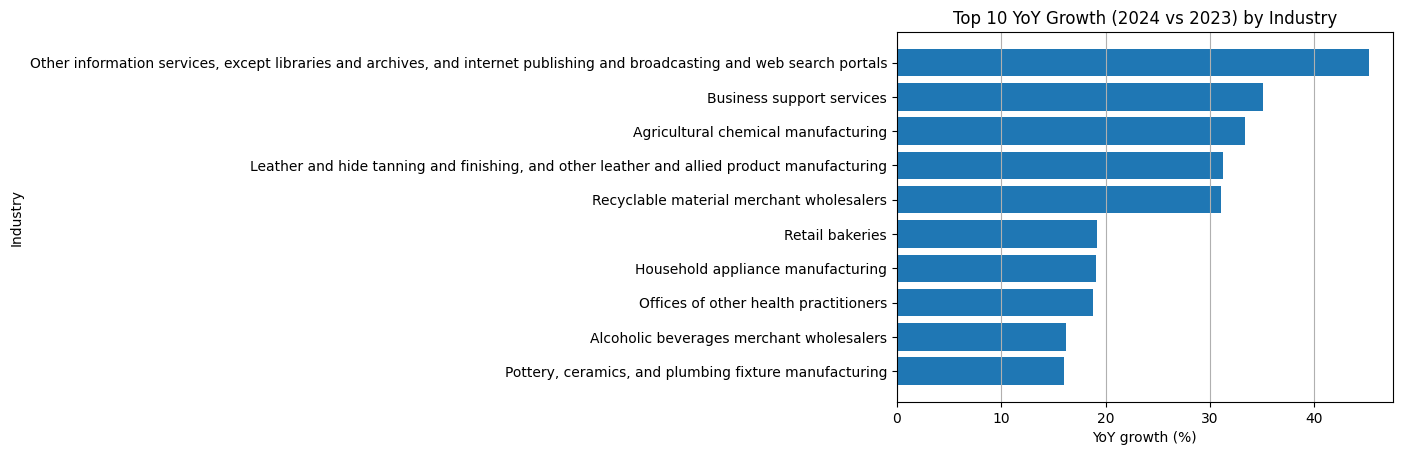

In [30]:
# 8) VIS 4: Biggest YoY movers in the most recent year (2024 vs 2023)
if (2024 in pivot_emp.index) and (2023 in pivot_emp.index):
    yoy_last = ((pivot_emp.loc[2024] - pivot_emp.loc[2023]) / pivot_emp.loc[2023] * 100).dropna()
    top_up = yoy_last.sort_values(ascending=False).head(10)
    plt.figure()
    plt.barh(top_up.index, top_up.values)
    plt.title("Top 10 YoY Growth (2024 vs 2023) by Industry")
    plt.xlabel("YoY growth (%)")
    plt.ylabel("Industry")
    plt.gca().invert_yaxis()
    plt.grid(axis="x")
    plt.show()
else:
    print("Insufficient data for 2024 vs 2023 YoY calculation.")

In [34]:
# 9) Modeling prep: panel with lags and next-year target
panel = emp_agg.sort_values(["Industry", "Year"]).copy()
panel["lag1"] = panel.groupby("Industry")["Employed_thousands"].shift(1)
panel["lag2"] = panel.groupby("Industry")["Employed_thousands"].shift(2)
panel["yoy_pct"] = (panel["Employed_thousands"] - panel["lag1"]) / panel["lag1"] * 100
panel["two_year_change"] = (panel["Employed_thousands"] - panel["lag2"]) / panel["lag2"] * 100
panel["target_next_year"] = panel.groupby("Industry")["Employed_thousands"].shift(-1)

train_ready = panel.dropna(subset=["lag1", "lag2", "target_next_year"]).reset_index(drop=True)
train_ready.head(20)

,Year,Industry,Employed_thousands,lag1,lag2,yoy_pct,two_year_change,target_next_year
0,2022,Aerospace products and parts manufacturing,77.000000,84.000000,44.000000,-8.333333,75.000000,44.000000
1,2023,Aerospace products and parts manufacturing,44.000000,77.000000,84.000000,-42.857143,-47.619048,46.000000
2,2020,Agricultural chemical manufacturing,35.000000,37.000000,37.000000,-5.405405,-5.405405,32.000000
3,2021,Agricultural chemical manufacturing,32.000000,35.000000,37.000000,-8.571429,-13.513514,27.000000
4,2022,Agricultural chemical manufacturing,27.000000,32.000000,35.000000,-15.625000,-22.857143,33.000000
5,2023,Agricultural chemical manufacturing,33.000000,27.000000,32.000000,22.222222,3.125000,44.000000
6,2020,Agricultural implement manufacturing,93.000000,97.000000,114.000000,-4.123711,-18.421053,130.000000
7,2021,Agricultural implement manufacturing,130.000000,93.000000,97.000000,39.784946,34.020619,133.000000
8,2022,Agricultural implement manufacturing,133.000000,130.000000,93.000000,2.307692,43.010753,148.000000
9,2023,Agricultural implement manufacturing,148.000000,133.000000,130.000000,11.278195,13.846154,118.000000


In [35]:
# 10) Inspect model-ready panel
train_ready.describe(include='all')


,Year,Industry,Employed_thousands,lag1,lag2,yoy_pct,two_year_change,target_next_year
count,550.000000,550,550.000000,550.000000,550.000000,547.000000,548.000000,550.000000
unique,NaN,144,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Agricultural chemical manufacturing,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
mean,2021.549091,NaN,1633.382424,1625.147091,1618.594879,0.381629,-0.245521,1664.808606
std,1.116342,NaN,3325.980162,3307.038182,3292.161801,17.181183,19.801809,3396.440581
min,2020.000000,NaN,0.000000,0.000000,0.000000,-100.000000,-100.000000,0.000000
25%,2021.000000,NaN,88.000000,88.250000,91.250000,-6.954069,-9.899834,88.000000
50%,2022.000000,NaN,317.000000,315.500000,313.500000,-0.606061,-1.232628,315.500000
75%,2023.000000,NaN,1167.583333,1167.583333,1167.583333,6.001607,6.941684,1201.500000


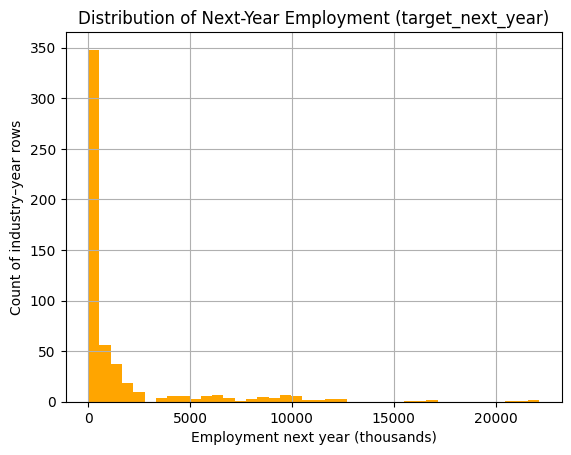

In [36]:
plt.figure()
train_ready["target_next_year"].hist(bins=40, color="orange")
plt.title("Distribution of Next-Year Employment (target_next_year)")
plt.xlabel("Employment next year (thousands)")
plt.ylabel("Count of industry–year rows")
plt.grid(True)
plt.show()


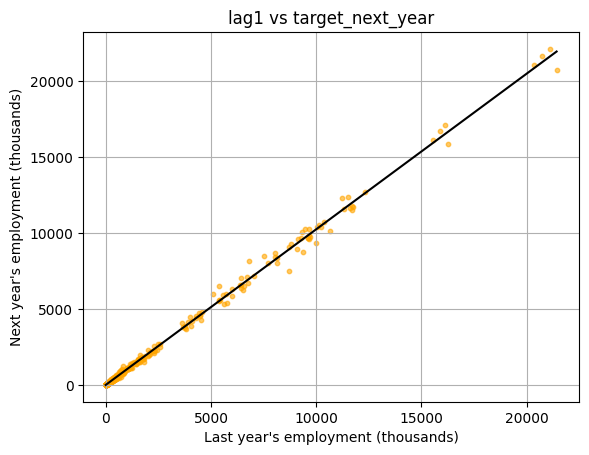

In [37]:
x = train_ready["lag1"].values
y = train_ready["target_next_year"].values
coef = np.polyfit(x, y, deg=1)
poly_fn = np.poly1d(coef)

plt.figure()
plt.scatter(x, y, s=10, alpha=0.6, color="orange")
xs = np.linspace(x.min(), x.max(), 200)
plt.plot(xs, poly_fn(xs), color="black")
plt.title("lag1 vs target_next_year")
plt.xlabel("Last year's employment (thousands)")
plt.ylabel("Next year's employment (thousands)")
plt.grid(True)
plt.show()


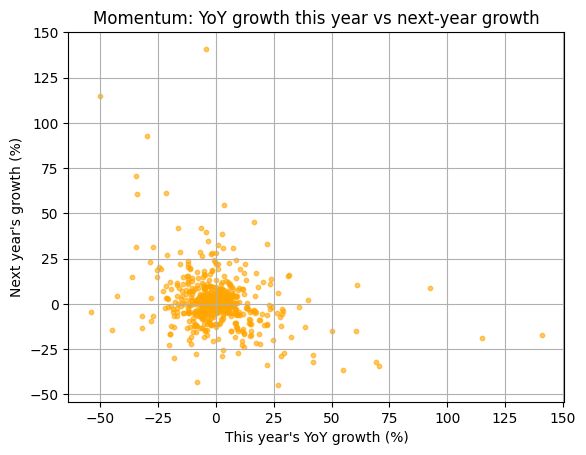

In [38]:
train_ready["next_year_growth_pct"] = (
    (train_ready["target_next_year"] - train_ready["Employed_thousands"])
    / train_ready["Employed_thousands"] * 100
)

plt.figure()
plt.scatter(train_ready["yoy_pct"], train_ready["next_year_growth_pct"],
            s=10, alpha=0.6, color="orange")
plt.title("Momentum: YoY growth this year vs next-year growth")
plt.xlabel("This year's YoY growth (%)")
plt.ylabel("Next year's growth (%)")
plt.grid(True)
plt.show()


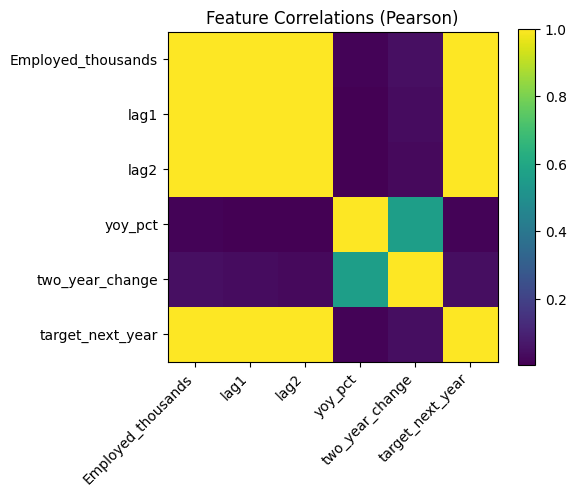

In [39]:
num_cols = ["Employed_thousands", "lag1", "lag2",
            "yoy_pct", "two_year_change", "target_next_year"]
corr = train_ready[num_cols].corr()

plt.figure(figsize=(6,5))
plt.imshow(corr, cmap="viridis", interpolation="nearest")
plt.title("Feature Correlations (Pearson)")
plt.colorbar()
plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha="right")
plt.yticks(range(len(num_cols)), num_cols)
plt.tight_layout()
plt.show()


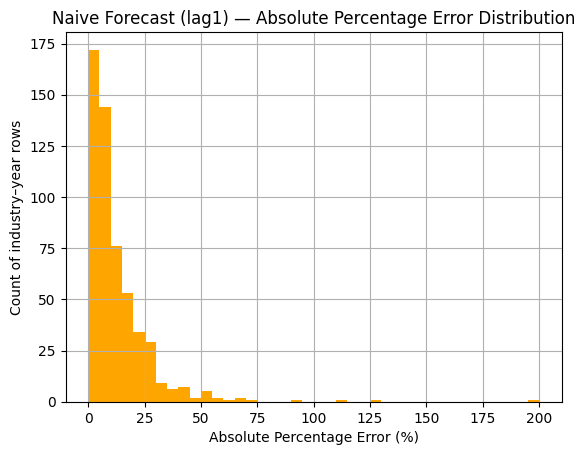

Lowest average APE (most stable industries):


,Industry,naive_ape
140,Wholesale and retail trade,1.023636
95,"Other services, private households",1.502368
119,Retail trade,1.708098
39,Financial activities,1.962914
80,Nonmetallic mineral mining and quarrying,1.970994
19,"Colleges, universities, and professional schoo...",2.345798
16,Chemicals manufacturing,2.574956
4,"Agriculture, forestry, fishing, and hunting",2.803783
3,Agriculture and related,2.808463
32,Educational services,3.800393



Highest average APE (most volatile industries):


,Industry,naive_ape
8,"Apparel, piece goods, and notions merchant who...",25.425587
73,Miscellaneous nondurable goods merchant wholes...,25.619551
132,Tobacco manufacturing,26.197479
18,Coal mining,33.948413
116,Recyclable material merchant wholesalers,34.935711
14,"Business, technical, and trade schools and tra...",38.804575
17,Clay building material and refractories manufa...,41.212652
121,Scenic and sightseeing transportation,65.016744
0,Aerospace products and parts manufacturing,79.150198
84,Not specified type of mining,inf


In [40]:
# Predict next year as lag1 (naive baseline)
train_ready["naive_pred"] = train_ready["lag1"]
train_ready["naive_abs_error"] = (train_ready["target_next_year"] - train_ready["naive_pred"]).abs()
train_ready["naive_ape"] = (train_ready["naive_abs_error"] /
                            train_ready["target_next_year"]) * 100

plt.figure()
train_ready["naive_ape"].clip(upper=200).hist(bins=40, color="orange")
plt.title("Naive Forecast (lag1) — Absolute Percentage Error Distribution")
plt.xlabel("Absolute Percentage Error (%)")
plt.ylabel("Count of industry–year rows")
plt.grid(True)
plt.show()

industry_naive = (
    train_ready.groupby("Industry")["naive_ape"]
    .mean()
    .reset_index()
    .sort_values("naive_ape")
)
print("Lowest average APE (most stable industries):")
display(industry_naive.head(10))
print("\nHighest average APE (most volatile industries):")
display(industry_naive.tail(10))
